In [5]:
#@title Install
!pip install wfdb > /dev/null 2>&1;

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: isysrgcom
"""
import wfdb
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import glob
from scipy.io import loadmat

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:

# BIDMC

# First get the list of available records and then download
# those records and store them in data_folder.
record_names = io.get_record_list('chfdb')
#io.dl_database('ptbdb', data_folder, record_names) // untuk download data ke folder

all_data = []
all_label = []




# IMPORT MITBIH HEALTH SINUS

paths_data = glob.glob('/content/drive/MyDrive/HeartDisease/Data/mit-bih-arrhythmia-database-1.0.0/*.dat', recursive=True)

for idx, dta in enumerate(paths_data):
    dataa = glob.glob(dta)
    for pathdata in dataa:
        pathdata = os.path.splitext(pathdata)[0]
        record = wfdb.rdrecord(pathdata,sampfrom=0)
        record_dict = record.__dict__
        sinyal = record_dict['p_signal'][:,0]
        all_data.append(sinyal)
        all_label.append(3)

len(all_data), all_label

(48,
 [3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3])

In [16]:

"""Discrete Wavelet Transform"""

import pywt
from statsmodels.robust import mad

#DISCRETE WAVELET TRANSFORM
mf = ['sym8']

hasil = []
for i in range(len(all_data)):
    data = []
    for j in range(len(mf)):
        w=pywt.Wavelet(mf[j])
        ca=[]
        cd=[]
        levels=8
        l = all_data[i]

        for level in range(levels):
            (l, h)=pywt.dwt(l, w)
            ca.append(l)
            cd.append(h)

        l = [0]*len(l)
        l=np.array(l)
        cd.append(l)

        tho = mad(cd[0])
        uthr = tho*np.sqrt(2*np.log(len(all_data[i])))

        new_cd = []
        for h in cd :
            new_cd.append(pywt.threshold(h, value=uthr, mode='soft')) #soft thresolding

        cd_rec = new_cd.copy()
        new_cd.reverse()
        new_signal = pywt.waverec(new_cd, w)
        data.append(new_signal)
        x = np.asarray(data)
        x= x.transpose()
        x = x.flatten()
        hasil.append(x)



"""Normalize Signal using Normalize Bound"""

from wfdb.processing import normalize_bound

normalisasi = []
for i in range(len(hasil)):
    x = normalize_bound(hasil[i], lb=0, ub=1)
    normalisasi.append(x)

"""Signal Segmentation"""

segment_all_signal = []
segment_all_label = []

for i in range(len(normalisasi)):

    temp_signal = normalisasi[i]
    pjg_sinyal = len(temp_signal)
    baca = all_label[i]

    for x in range(0, len(temp_signal), 2700):

        N = (2700+x) - pjg_sinyal
        if (x+2700 < pjg_sinyal):
            ritme = temp_signal[x:x+2700]
            segment_all_signal.append(ritme)
            segment_all_label.append(baca)

        elif(N<2600):
            ritme= temp_signal[x:x+2700]
            ritme = np.pad(ritme, (0, N), 'constant')
            segment_all_signal.append(ritme)
            segment_all_label.append(baca)

for i in range(len(segment_all_label)):
    all_data.append(segment_all_signal[i])
    all_label.append(segment_all_label[i])

sum(float(num) == 8 for num in all_label) #Check Data for every label

#Splitting Dataset
all_data, sinyal_unseen, all_label, label_unseen=train_test_split(segment_all_signal, segment_all_label,test_size=0.1)


# """Pickling Data"""

import pickle

with open('/content/drive/MyDrive/HeartDisease/Data/mit-bih-arrhythmia-database-1.0.0/DATA2700/DATA2700', 'wb') as f:
    pickle.dump(all_data, f)

with open('/content/drive/MyDrive/HeartDisease/Data/mit-bih-arrhythmia-database-1.0.0/DATA2700/LABEL2700', 'wb') as f:
    pickle.dump(all_label, f)




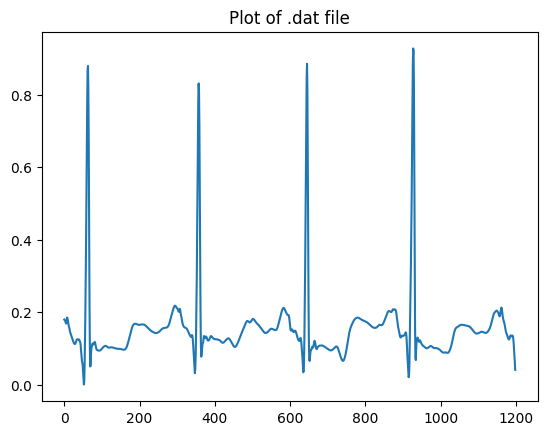

In [17]:

signal = all_data[0][1:1200]
plt.plot(signal)
plt.title('Plot of .dat file')
plt.show()